# Install detectron2

In [1]:
!pip install pyyaml==5.2

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch:  1.11 ; cuda:  cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.11/index.html
ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


# Use GPU

In [1]:
import torch
torch.cuda.is_available()

True

# Download Data


In [2]:
workspace_dir = '.'

# gdown is a package that downloads files from google drive
!gdown --id 1f3y6Wbessm-qC3WvaretMf46UL8MLPfU \
    --output "{workspace_dir}/data.zip"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f3y6Wbessm-qC3WvaretMf46UL8MLPfU
To: /content/data.zip
100% 63.2M/63.2M [00:01<00:00, 61.6MB/s]


## Decompress the dataset

In [3]:
import zipfile
import pathlib


data_dir = 'data'
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Some basic setup

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random, cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import pycocotools.mask as mask_util

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Register Dataset


In [ ]:
#register custom datasets to Detectron2
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_data", {}, "data/dataset/train/train.json", "data/dataset/train/images")

In [ ]:
# get the information of dataset
coco_metadata = MetadataCatalog.get("train_data")
dataset_dicts = DatasetCatalog.get("train_data")
coco_metadata

[12/16 11:59:52 d2.data.datasets.coco]: Loading dataset/train/train.json takes 1.43 seconds.
[12/16 11:59:52 d2.data.datasets.coco]: Loaded 24 images in COCO format from dataset/train/train.json


Metadata(evaluator_type='coco', image_root='dataset/train/images', json_file='dataset/train/train.json', name='train_data', thing_classes=['nucleus'], thing_dataset_id_to_contiguous_id={1: 0})

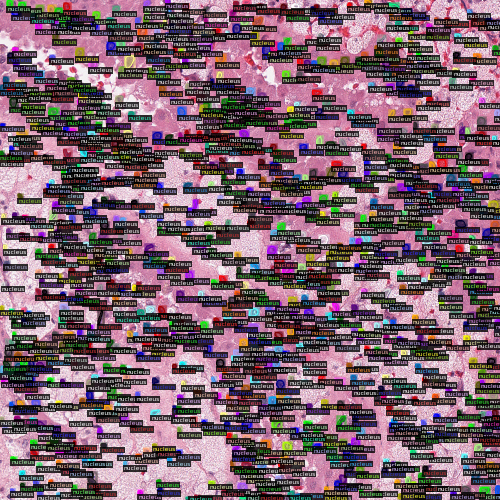

In [ ]:
#visualize the dataset 
import random

for d in random.sample(dataset_dicts,1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:,:,::-1], metadata = coco_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:,:,::-1])
    #cv2.imwrite('image.jpg', vis.get_image()[:,:,::-1])

# Train

In [ ]:
# load basic setting
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")) #ResNeXt 101
cfg.DATASETS.TRAIN = ("train_data",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (balloon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [ ]:
# train and save model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/15 10:55:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/15 10:55:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd81003a830> to CPU due to CUDA OOM
[12/15 10:57:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd81003a830> to CPU due to CUDA OOM
[12/15 10:57:15 d2.utils.events]:  eta: 2:33:43  iter: 19  total_loss: 1.225  loss_cls: 0.1807  loss_box_reg: 0.2807  loss_mask: 0.3213  loss_rpn_cls: 0.1274  loss_rpn_loc: 0.2649  time: 4.8541  data_time: 0.0830  lr: 4.9953e-06  max_mem: 9475M
[12/15 10:57:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd81003a830> to CPU due to CUDA OOM
[12/15 10:58:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd81003a830> to CPU due to CUDA OOM
[12/15 10:58:23 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7fd81003a830> to CPU due to CUDA OOM
[12/15 10:58:51 d2.utils.events]:  eta: 2:24:18  iter: 39  total_loss: 1.195  loss_cls: 0.1576  loss_box_reg: 0.290

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

# Predict

In [ ]:
def instances_to_coco_json(instances, img_id, results):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    #results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": 1,
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt
import cv2
import os

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.TEST.DETECTIONS_PER_IMAGE = 2500
predictor = DefaultPredictor(cfg)

test_dir = "data/dataset/test"
test_set = "data/dataset/test_img_ids.json"

with open(test_set) as f:
    test_data = json.load(f)

result_to_json = []
json_name = os.path.join('{}/annotations/{}'.format(cfg.OUTPUT_DIR,'answer.json'))

for d in test_data:
  im = cv2.imread(os.path.join(test_dir , d["file_name"]))
  outputs = predictor(im)

  #visualize and save the result
  v = Visualizer(im[:, :, ::-1],
            metadata=coco_metadata,
            scale=0.5,
            instance_mode=ColorMode.IMAGE_BW)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)
  plt.imsave(os.path.join(os.path.join(cfg.OUTPUT_DIR, 'visualization'), str(d["id"]) + '.png'), img)

  #save the answer result
  answer = outputs["instances"].to("cpu")
  result = instances_to_coco_json(answer, d["id"], result_to_json)

save_to_json(result_to_json)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


Save annotation to ./output/annotations/answer.json


In [ ]:
class MyEncoder(json.JSONEncoder):
  def default(self,obj):
    if isinstance(obj,np.ndarray):
      return obt.tolist()
    elif isinstance(obj,bytes):
      return str(obj, encoding = 'utf-8')
    return json.JSONEncoder.default(self,obj)

In [ ]:
# save result to json
def save_to_json(result_to_json):
  folder = os.path.join(cfg.OUTPUT_DIR, 'annotations')
  if not os.path.exists(folder):
      os.makedirs(folder)

  json_name = os.path.join('{}/annotations/{}'.format(cfg.OUTPUT_DIR,'answer.json'))
  with open(json_name, 'w') as f:
      json.dump(result_to_json, f, cls = MyEncoder)
      print('Save annotation to {}'.format(json_name))